In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
import math
import os
from scipy.linalg import svd
from tqdm.notebook import tqdm
import copy
import random

# Part II - Normalized 8-Point Algorithm

In [2]:
image_list = []
img_dir = "C:/Users/ksevi/OneDrive/Desktop/MASTER/VISUAL PRECEPTION/RENATO/CV_Assignment_3_Epipolar/images/"
filenames = os.listdir(img_dir)
filenames = sorted(filenames)
for img in tqdm(filenames):
    img_path = os.path.join(img_dir, img)
    image_list.append(img_path)

  0%|          | 0/4 [00:00<?, ?it/s]

In [3]:
image_list

['C:/Users/ksevi/OneDrive/Desktop/MASTER/VISUAL PRECEPTION/RENATO/CV_Assignment_3_Epipolar/images/image_left.jpg',
 'C:/Users/ksevi/OneDrive/Desktop/MASTER/VISUAL PRECEPTION/RENATO/CV_Assignment_3_Epipolar/images/image_right.jpg',
 'C:/Users/ksevi/OneDrive/Desktop/MASTER/VISUAL PRECEPTION/RENATO/CV_Assignment_3_Epipolar/images/pt_2D_left.txt',
 'C:/Users/ksevi/OneDrive/Desktop/MASTER/VISUAL PRECEPTION/RENATO/CV_Assignment_3_Epipolar/images/pt_2D_right.txt']

In [4]:
left_image = cv2.imread(image_list[0])
right_image = cv2.imread(image_list[1])
grayscale_left = cv2.cvtColor(left_image, cv2.COLOR_BGR2GRAY)
grayscale_right = cv2.cvtColor(right_image, cv2.COLOR_BGR2GRAY)

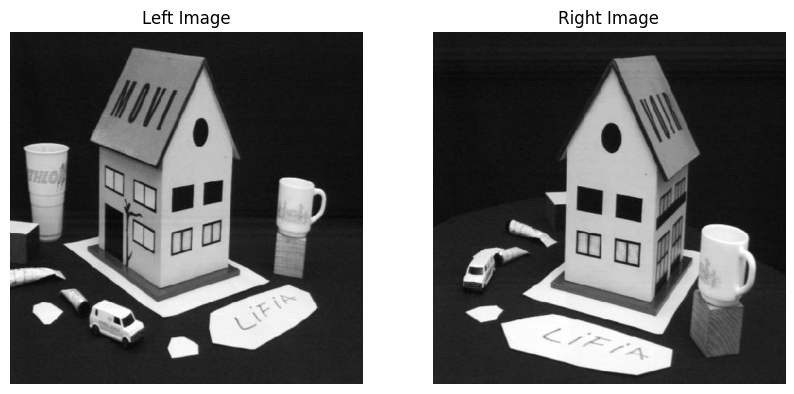

In [5]:
# Create a figure and axis with two subplots in a single row
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Display the left grayscale image in the first subplot
ax[0].imshow(grayscale_left, cmap='gray')
ax[0].set_title('Left Image')
ax[0].axis('off')

# Display the right grayscale image in the second subplot
ax[1].imshow(grayscale_right, cmap='gray')
ax[1].set_title('Right Image')
ax[1].axis('off')

# Show the plot
plt.show()

In [6]:
def extract_coords(file_path):
    pos_list = []  
    with open(file_path, 'r') as file_obj:
        for line in file_obj:
            coords = line.strip().split()
            coord_pair = (float(coords[1]), float(coords[0]))
            pos_list.append(coord_pair)
    return pos_list

In [7]:
kps_1_ = extract_coords(image_list[2])
kps_1 = np.array([np.append(coord, 1) for coord in kps_1_])
kps_2_ = extract_coords(image_list[3])
kps_2 = np.array([np.append(coord, 1) for coord in kps_2_])

In [8]:
def plot_correspondences(left_image, right_image, pt1, pt2):
    # Get the dimensions of the input images
    hL, wL = left_image.shape[:2]
    hR, wR = right_image.shape[:2]
    combined_image = np.zeros((max(hL, hR), wL + wR, 3), dtype="uint8")
    combined_image[0:hL, 0:wL] = left_image
    combined_image[0:hR, wR:] = right_image
    for point1, point2 in zip(pt1, pt2):
        x1, y1 = map(int, point1)
        x2, y2 = map(int, point2)
        cv2.line(combined_image, (x1, y1), (x2 + wL, y2), (250, 28, 100), 1)
    plt.imshow(combined_image)
    plt.show()

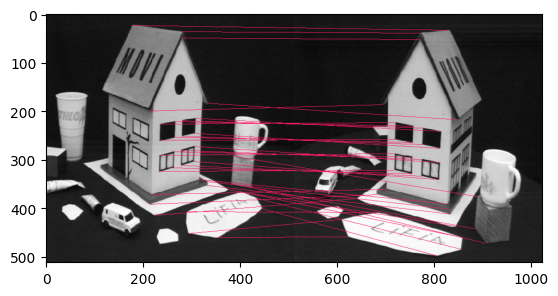

In [9]:
plot_correspondences(left_image, right_image, kps_1_, kps_2_)

###### 1. Data conditioning: In [1] Hartley proposed a pre-processing step to normalize the image points for better numerical conditioning. This normalization involves applying an affine transformation to the pixel coordinates of each image (as seen during the class lecture).

In [10]:
def data_conditioning(kps):
    mean_coords = np.mean(kps, axis=0)
    centered_coords = kps - mean_coords
    
    distances = np.linalg.norm(centered_coords, axis=1)
    avg_distance = np.mean(distances)
    scale_factor = np.sqrt(2) / avg_distance

    translation_matrix = np.eye(3)
    translation_matrix[:2, 2] = - mean_coords[:2]

    scal_matrix = np.eye(3) * scale_factor
    scal_matrix[2, 2] = 1

    transform_matrix = scal_matrix @ translation_matrix
    norm_coords = (transform_matrix @ kps.T).T

    return norm_coords, transform_matrix

In [11]:
n_p1, Tr_p1 = data_conditioning(kps_1)
n_p2, Tr_p2 = data_conditioning(kps_2)

In [12]:
n_p1

array([[ 1.71559183,  0.88586848,  1.        ],
       [ 0.10430749, -0.64278588,  1.        ],
       [ 0.47614234, -1.49662886,  1.        ],
       [-0.88870794, -0.43719778,  1.        ],
       [-0.8872521 , -0.89756161,  1.        ],
       [-0.90488317,  0.44259609,  1.        ],
       [-0.24162017, -1.00012451,  1.        ],
       [-0.26098825,  0.26869608,  1.        ],
       [-0.2697792 , -0.14846908,  1.        ],
       [-1.67223677, -3.70009462,  1.        ],
       [ 0.44859902,  0.72060855,  1.        ],
       [-0.06095244,  2.19417628,  1.        ],
       [ 1.15095373,  0.78946686,  1.        ],
       [ 1.0545521 ,  0.95472679,  1.        ],
       [ 0.46237068,  0.83078184,  1.        ],
       [-1.16268532, -1.27628229,  1.        ],
       [-0.47410227, -0.11946277,  1.        ],
       [ 2.01856837,  1.49182157,  1.        ],
       [ 1.83953678,  1.18884503,  1.        ],
       [ 1.48773069,  1.03496916,  1.        ],
       [ 0.77911888,  2.30434957,  1.   

###### 2. Linear estimation: from the epipolar constraint equation (as shown in the slides of the class and in Chapter 11 of [2]), build the linear system with the entries of F as the unknowns and solve it using SVD. How many correspondences are required?

 We need a minimum of 8 point correspondences to estimate the fundamental matrix F using the linear approach.
 
 In the context of the 8-point algorithm, a minimum of 8 point correspondences is required to compute the fundamental matrix. The algorithm gets its name from this requirement. These 8 point correspondences should be non-collinear to ensure a unique solution.

However, in practice, it is better to have more than 8 correspondences to improve the accuracy and robustness of the estimation. When you have more than 8 correspondences, the algorithm becomes an overdetermined linear system, and you can solve it using the least-squares method.

In [13]:
def linear_estimation(p1, p2):
    A_matrix = []
    for i in range(p1.shape[0]):
        u1, v1, _ = p1[i]
        u2, v2, _ = p2[i]
        #  at leas 8 point correspondences
        A_matrix.append([u1*u2, v1*u2, u2, u1*v2, v1*v2, v2, u1, v1, 1])

    A = np.array(A_matrix)
    #print(A.shape)
    _, _, Vt = np.linalg.svd(A)
    F = Vt[-1].reshape(3, 3)
    return F

In [14]:
F_lin = linear_estimation(n_p1, n_p2)

###### 3. Enforce rank-2 condition: the estimated matrix may not necessarily satisfy the rank-2 condition of a Fundamental matrix. Enforce this constraint explicitly using SVD by setting the last singular value to 0.

In [15]:
def enforce_rank2_condition(F):
    U, s, V = np.linalg.svd(F)
    #last singular value to 0
    s[-1] = 0
    F_rank2 = U @ np.diag(s) @ V
    return F_rank2

In [16]:
F_rank2 = enforce_rank2_condition(F_lin)

###### 4. Denormalize your estimated fundamental matrix.

In [17]:
def denormalize_fundamental_matrix(F_rank2, T_p1, T_p2):
    F_denorm = T_p2.T @ F_rank2 @ T_p1
    return F_denorm

In [18]:
F_denorm = denormalize_fundamental_matrix(F_rank2, Tr_p1, Tr_p2)
print(F_denorm)

[[ 7.69564303e-07 -5.78773950e-06 -1.01011620e-03]
 [-6.28660670e-06 -4.01132413e-07  1.04176782e-02]
 [ 1.04182564e-04 -7.58583623e-03  1.72255185e-01]]


###### 5. Implement a RANSAC algorithm and combine it with your Fundamental matrix estimation to find a fundamental matrix robust to outliers.

In [19]:
def ransac_fundamental_matrix(p1, p2, threshold=1e-4, iterations=1000):
    max_inliers = 0
    optimal_F = None
    num_points = p1.shape[0]

    for _ in range(iterations):
        random_indices = random.sample(range(num_points), 8)
        selected_p1 = p1[random_indices]
        selected_p2 = p2[random_indices]

        # Estimar la matriz fundamental
        F_lin = linear_estimation(selected_p1, selected_p2)
        F_rank2 = enforce_rank2_condition(F_lin)

        # Contar inliers
        inlier_count = 0
        for i in range(num_points):
            num = np.square(np.dot(p2[i].T, np.dot(F_rank2, p1[i])))
            den1 = np.square(np.dot(F_rank2, p1[i])[0]) + np.square(np.dot(F_rank2, p1[i])[1])
            den2 = np.square(np.dot(F_rank2.T, p2[i])[0]) + np.square(np.dot(F_rank2.T, p2[i])[1])
            sampson_dist = num / (den1 + den2)
            
            if sampson_dist < threshold:
                inlier_count += 1

        # Actualizar la matriz fundamental Ã³ptima si es necesario
        if inlier_count > max_inliers:
            max_inliers = inlier_count
            optimal_F = F_rank2

    return optimal_F

In [32]:
F_ransac = ransac_fundamental_matrix(n_p1, n_p2)
F_ransac_denorm = denormalize_fundamental_matrix(F_ransac, Tr_p1, Tr_p2)

In [33]:
print(F_ransac_denorm)

[[-7.51300007e-07  6.35231802e-06  8.44538641e-04]
 [ 6.47348362e-06  5.11363404e-07 -1.04946276e-02]
 [-2.04512907e-04  7.41438843e-03 -1.01241613e-01]]


# Part III - Fundamental Matrix Estimation Tests

###### 1. Using your implemented algorithm, compute the Fundamental matrix and visualize the epipolar lines using the provided ground-truth correspondences. You should obtain a similar result as shown in Figure 1.

In [22]:
def visual_epipolar_lines(img_L, img_R, kps1, kps2, F, tag):
    pts1 = np.int32(kps1[:, 0:2])
    pts2 = np.int32(kps2[:, 0:2])
    lines1 = cv2.computeCorrespondEpilines(pts2.reshape(-1, 1, 2), 2, F)
    lines1 = lines1.reshape(-1, 3)

    r, c, _ = img_L.shape
    for r, pt1, pt2 in zip(lines1, pts1, pts2):
        color = tuple(np.random.randint(0, 255, 3).tolist())
        x0, y0 = map(int, [0, -r[2] / r[1]])
        x1, y1 = map(int, [c, -(r[2] + r[0] * c) / r[1]])
        img_L = cv2.line(img_L, (x0, y0), (x1, y1), color, 1)
        img_L = cv2.circle(img_L, tuple(pt1), 5, color, -1)
        img_R = cv2.circle(img_R, tuple(pt2), 5, color, -1)

    lines2 = cv2.computeCorrespondEpilines(pts1.reshape(-1, 1, 2), 1, F)
    lines2 = lines2.reshape(-1, 3)

    r, c, _ = img_R.shape
    for r, pt1, pt2 in zip(lines2, pts2, pts1):
        color = tuple(np.random.randint(0, 255, 3).tolist())
        x0, y0 = map(int, [0, -r[2] / r[1]])
        x1, y1 = map(int, [c, -(r[2] + r[0] * c) / r[1]])
        img_R = cv2.line(img_R, (x0, y0), (x1, y1), color, 1)
        img_R = cv2.circle(img_R, tuple(pt1), 5, color, -1)
        img_L = cv2.circle(img_L, tuple(pt2), 5, color, -1)

    plt.subplot(121), plt.imshow(img_L)
    plt.subplot(122), plt.imshow(img_R)
    plt.show()
    return lines1, lines2

In [23]:
left_copy = left_image.copy()
right_copy = right_image.copy()

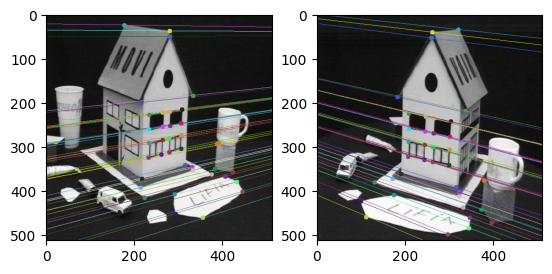

In [24]:
lines1, lines2 = visual_epipolar_lines(left_copy, right_copy, kps_1, kps_2, F_denorm, tag="custom")

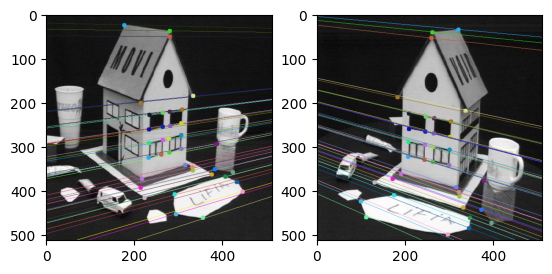

In [34]:
left_copy = left_image.copy()
right_copy = right_image.copy()
lines1, lines2 = visual_epipolar_lines(left_copy, right_copy, kps_1, kps_2,  F_ransac_denorm, tag="custom")

###### 2. Compute the estimation error as the average epipolar distance i.e. the average distance from each point to its epipolar line.

In [26]:
def epipolar_dist(pts, lines):
    num_pts = pts.shape[0]
    dist = np.zeros(num_pts)
    for i in range(num_pts):
        a, b, c = lines[i]
        x, y = pts[i]
        distance = abs(a * x + b * y + c) / np.sqrt(a * a + b * b)
        dist[i] = distance
    return dist

def avg_epipolar_dist(kps_1, kps_2, F):
    pts_1 = np.int32(kps_1[:, 0:2])
    pts_2 = np.int32(kps_2[:, 0:2])

    lines1 = cv2.computeCorrespondEpilines(pts_2.reshape(-1, 1, 2), 2, F)
    lines_1 = lines1.reshape(-1, 3)
    lines2 = cv2.computeCorrespondEpilines(pts_1.reshape(-1, 1, 2), 1, F)
    lines_2 = lines2.reshape(-1, 3)

    dist_1 = epipolar_dist(pts_1, lines_1)
    dist_2 = epipolar_dist(pts_2, lines_2)

    avg_dist = (np.mean(dist_1) + np.mean(dist_2)) / 2

    return avg_dist


In [35]:
avg_distance_F_denorm = avg_epipolar_dist(kps_1, kps_2, F_denorm)
print("Average epipolar distance in F_denorm:", avg_distance_F_denorm)

Average epipolar distance in F_denorm: 0.9335650623616543


In [36]:
avg_distance_F_ransac = avg_epipolar_dist(kps_1, kps_2, F_ransac_denorm)
print("Average epipolar distance in F_ransac:", avg_distance_F_ransac)

Average epipolar distance in F_ransac: 0.9505061565558812


###### 3. Test the performance with noise in the image point correspondences:


(a) Add noise to the pixel coordinates (zero-mean Gaussian noise with an increasing value of the standard deviation, s=0.5, 1, 1.5 ... pixels ), and repeat the above steps.

(b) Observe (and report) the effect of noise on the estimation error with and without RANSAC.

In [37]:
def add_gaussian_noise(kps, mean=0, std=1):
    noise_kp = kps.copy()
    noise = np.random.normal(mean, std, kps.shape)
    noise_kp[:, :2] += noise[:, :2]
    return noise_kp

std_values = [0, 0.5, 1, 1.5, 2]
errors_no_ransac = []
errors_ransac = []

for std in std_values:
    # Add Gaussian noise to the keypoints
    noisy_kps1 = add_gaussian_noise(kps_1, mean=0, std=std)
    noisy_kps2 = add_gaussian_noise(kps_2, mean=0, std=std)

    F_den = F_denorm

    F_ransac = F_ransac_denorm

    # Calculate the average epipolar distance for both methods
    avg_distance_no_ransac = avg_epipolar_dist(noisy_kps1, noisy_kps2, F_den)
    avg_distance_ransac = avg_epipolar_dist(noisy_kps1, noisy_kps2, F_ransac)

    errors_no_ransac.append(avg_distance_no_ransac)
    errors_ransac.append(avg_distance_ransac)

In [38]:
print("Errors without RANSAC:", errors_no_ransac)
print("Errors with RANSAC:", errors_ransac)

Errors without RANSAC: [0.9335650623616543, 1.06547029750088, 1.2288395448379674, 1.8098986773299528, 2.8062284994689333]
Errors with RANSAC: [0.9505061565558812, 1.1054399363436083, 1.3863189297663652, 1.6671796959309177, 2.7701327685547588]


# Part IV - Estimation of the Fundamental Matrix with Detected and Described Features
We will now use the SIFT detector and descriptor for extracting real features, instead of the ground
truth correspondences.

###### 1. Detect and extract features of the images using SIFT. For having more keypoints you can change the value of contrastThreshold of SIFT.

In [39]:
sift = cv2.SIFT_create(contrastThreshold=0.04)
kp1, des1 = sift.detectAndCompute(grayscale_left, None)
kp2, des2 = sift.detectAndCompute(grayscale_right, None)

###### 2. Perform the matching between the descriptors from SIFT using brute force matching.

In [41]:
bf = cv2.BFMatcher()
matches = bf.knnMatch(des1, des2, k=2)

###### 3. Remove outliers using SIFT ratio and cross validation tests. Please show plots of the corresponding keypoints before and after the outlier removal

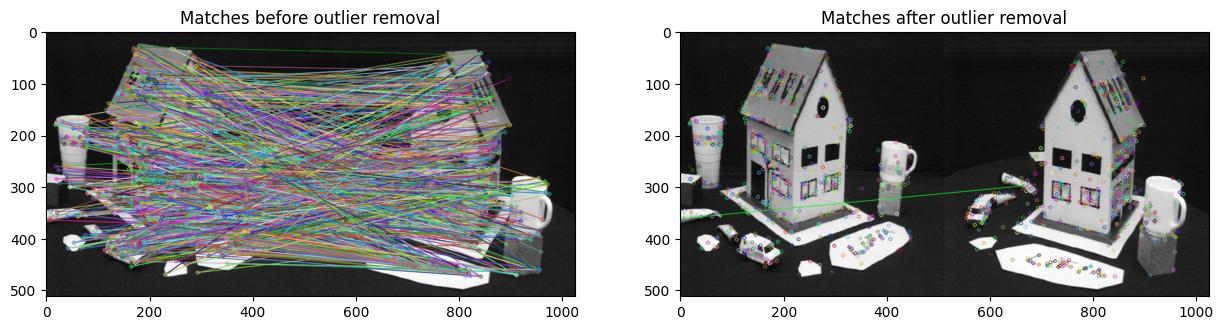

In [42]:
#Before the outlier removal
img_matches_before = cv2.drawMatchesKnn(grayscale_left, kp1, grayscale_right, kp2, matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

#ratio test de SIFT
ratio_threshold = 0.8
good_matches = []
for m, n in matches:
    if m.distance < ratio_threshold * n.distance:
        good_matches.append(m)

#Cross validation
cross_validated_matches = []
for m in good_matches:
    query_idx = m.queryIdx
    train_idx = m.trainIdx
    m_rev = bf.match(des2[train_idx].reshape(1, -1), des1[query_idx].reshape(1, -1))[0]
    if m_rev.trainIdx == query_idx:
        cross_validated_matches.append(m)

#after the outlier removal
img_matches_after = cv2.drawMatches(grayscale_left, kp1, grayscale_right, kp2, cross_validated_matches, None)

plt.figure(figsize=(15, 15))
plt.subplot(121)
plt.imshow(img_matches_before)
plt.title('Matches before outlier removal')
plt.subplot(122)
plt.imshow(img_matches_after)
plt.title('Matches after outlier removal')
plt.show()

###### 4. Compute the fundamental matrix and estimation error done in Part III. What you can observe compared to the case of using the ground-truth correspondences? What can you do for improving this result?

The average epipolar distance is higher for SIFT correspondences compared to ground-truth correspondences. To improve results, we could consider these approaches:

Image Rectification: Transform images to align epipolar lines horizontally, simplifying correspondence finding and reducing errors.

Projective Transformation: Align images with different perspectives before computing correspondences and the fundamental matrix.


In [43]:
num_cross_validated_matches = len(cross_validated_matches)

if num_cross_validated_matches < 8:
    print("Not enough validated matches. Using good_matches instead.",num_cross_validated_matches)
    matches_to_use = good_matches
else:
    matches_to_use = cross_validated_matches

src_pts = np.float32([kp1[m.queryIdx].pt for m in matches_to_use]).reshape(-1, 1, 2)
dst_pts = np.float32([kp2[m.trainIdx].pt for m in matches_to_use]).reshape(-1, 1, 2)

homogeneous_src_pts = np.hstack((src_pts.reshape(-1, 2), np.ones((src_pts.shape[0], 1))))
homogeneous_dst_pts = np.hstack((dst_pts.reshape(-1, 2), np.ones((dst_pts.shape[0], 1))))
n_p1_sift, Tr_p1_sift = data_conditioning(homogeneous_src_pts)
n_p2_sift, Tr_p2_sift = data_conditioning(homogeneous_dst_pts)
F_ransac_sift = ransac_fundamental_matrix(n_p1_sift, n_p2_sift)

#fundamental matrix sift
F_ransac_denorm_sift = denormalize_fundamental_matrix(F_ransac_sift, Tr_p1_sift, Tr_p2_sift)

Not enough validated matches. Using good_matches instead. 1


In [44]:
def epipolar_dist_sift(pts, lines):
    num_pts = pts.shape[0]
    a, b, c = lines.T
    x, y = pts[:, 0], pts[:, 1]
    distance = np.abs(a * x + b * y + c) / np.sqrt(a * a + b * b)
    return distance

def avg_epipolar_dist_sift(kps_1, kps_2, F, good_matches):
    pts_1 = np.int32([kps_1[m.queryIdx].pt for m in good_matches])
    pts_2 = np.int32([kps_2[m.trainIdx].pt for m in good_matches])

    lines1 = cv2.computeCorrespondEpilines(pts_2.reshape(-1, 1, 2), 2, F)
    lines_1 = lines1.reshape(-1, 3)
    lines2 = cv2.computeCorrespondEpilines(pts_1.reshape(-1, 1, 2), 1, F)
    lines_2 = lines2.reshape(-1, 3)

    dist_1 = epipolar_dist_sift(pts_1, lines_1)
    dist_2 = epipolar_dist_sift(pts_2, lines_2)

    avg_dist = (np.mean(dist_1) + np.mean(dist_2)) / 2

    return avg_dist

In [46]:
avg_distance_F_SIFT = avg_epipolar_dist_sift(kp1, kp2, F_ransac_denorm_sift, matches_to_use)
print("Average epipolar distance in F_denorm sift :", avg_distance_F_SIFT)

Average epipolar distance in F_denorm sift : 85.42800259780047
